## **Fastai Tutorial**
In this notebook, we will be learning about uploading our dataset to drive and using it with colab and creating a simple classifier using fastai library.

We will be using **17 Category Flower Dataset** from the **Visual Geometry Group of University of Oxford**(Fun fact-This group participated in the ImageNet Competition of 2014 and secured 1st and 2nd place in localization and classification tasks respectively under name ***VGG***, and also denoted the same name in the paper for their model) for our the tutorial. It has 17 classes each carrying 80 images. The flowers chosen are some common flowers in the UK. The images have large scale, pose and light variations and there are also classes with large varations of images within the class and close similarity to other classes.

Why fastai? Well fastai performs well out of the box in a very few lines of code. It could be a great tool for prototyping solutions fast.
 
### Requirement - 
Download the file under **Dataset Images** by clicking on it from [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html) and upload it to your google drive of the account you're using colab with.



Let's first mount the google drive on colab, it will allow us to use files on
our drives. Run this cell and follow along with the instructions shown.

In [ ]:
from google.colab import drive
drive.mount('drive')

Please change the path accordingly if you have uploaded the dataset in some
other folder. You can check the path by clicking on the left pane button,
under the files sections, using the drop down menu.

In [ ]:
!cp "/content/drive/My Drive/17flowers.tgz" "."

In [ ]:
# Just in case, you want a quick start
#!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz

In [ ]:
# Extracting the dataset 
!tar -xzf 17flowers.tgz

In [ ]:
import os
import re
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split

import fastai
from fastai.vision import *

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(77)

Let's get all the images from the dataset

In [ ]:
all_image_files = glob("./jpg/*.jpg")

In [ ]:
assert (len(all_image_files) == 1360), print("Some files are missing")

The files are arranged such that 80 images belong to one class
what that means is image_1 to image_80 belong to class 1,
image_81 to image_160 belong to class 2, and so on.

In [ ]:
df = pd.DataFrame()
df['image_names'] = all_image_files
df.head()

,image_names
0,./jpg/image_0500.jpg
1,./jpg/image_1224.jpg
2,./jpg/image_1143.jpg
3,./jpg/image_0458.jpg
4,./jpg/image_0285.jpg


In [ ]:
# Creating a dictionary for mapping image numbers to their respective classes
img_num_to_class = {}
j = 1
for i in range(1, 1361):
    img_num_to_class[i] = j
    if i%80==0:
        j = j + 1

In [ ]:
# Just santity checking
assert img_num_to_class[79] == 1, print('Classes are not properly assigned')
assert img_num_to_class[81] == 2, print('Classes are not properly assigned')
assert img_num_to_class[1360] == 17, print('Classes are not properly assigned')

Let's extract the image number from the names

In [ ]:
# df['labels'] = df['image_names'].apply(lambda x: int(x.split('/')[2].split('_')[1].split('.')[0])) //80
df['img_number'] = df['image_names'].apply(lambda x: re.findall(r'\d+', x)[0]).astype(int) 
df['labels'] = df['img_number'].replace(img_num_to_class)
df.head(10)

,image_names,img_number,labels
0,./jpg/image_0500.jpg,500,7
1,./jpg/image_1224.jpg,1224,16
2,./jpg/image_1143.jpg,1143,15
3,./jpg/image_0458.jpg,458,6
4,./jpg/image_0285.jpg,285,4
5,./jpg/image_0112.jpg,112,2
6,./jpg/image_0848.jpg,848,11
7,./jpg/image_1350.jpg,1350,17
8,./jpg/image_1153.jpg,1153,15
9,./jpg/image_0650.jpg,650,9


In [ ]:
# Keeping the test set small, due to small dataset
X_train, X_test = train_test_split(df, test_size=0.1, random_state=42)

In [ ]:
y_test = X_test['labels'].copy()
X_test = X_test.drop('labels', axis=1)

In [ ]:
tfms = get_transforms(flip_vert=False)

src = (ImageList.from_df(path='.', df=df)
        #Where to find the data? -> in path and from this dataframe
       .split_by_rand_pct(0.2, seed=42)
        #How to split in train/valid? -> random split
       .label_from_df(cols='labels')
        #How to label? -> using value from the column 
       )
src

LabelLists;

Train: LabelList (1088 items)
x: ImageList
Image (3, 500, 545),Image (3, 511, 499),Image (3, 533, 500),Image (3, 500, 511),Image (3, 750, 500)
y: CategoryList
7,16,15,6,4
Path: .;

Valid: LabelList (272 items)
x: ImageList
Image (3, 767, 500),Image (3, 500, 625),Image (3, 500, 666),Image (3, 500, 705),Image (3, 500, 666)
y: CategoryList
10,15,13,16,11
Path: .;

Test: None

In [ ]:
data = (src.transform(tfms=tfms, size=128, resize_method=ResizeMethod.SQUISH)
        #Data augmentation? -> use tfms with a size of 64 and resize images by squishing
       .databunch(bs=64, num_workers=2)
        #Finally? -> use bs of 64 for conversion to ImageDataBunch
       )
data

ImageDataBunch;

Train: LabelList (1088 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
7,16,15,6,4
Path: .;

Valid: LabelList (272 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
10,15,13,16,11
Path: .;

Test: None

In [ ]:
# Name of classes and number of classes
data.classes, data.c

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 17)

Let's take a look at the dataset.
You can change the `ds_type` to `DatasetType.Valid`
for looking at validation images

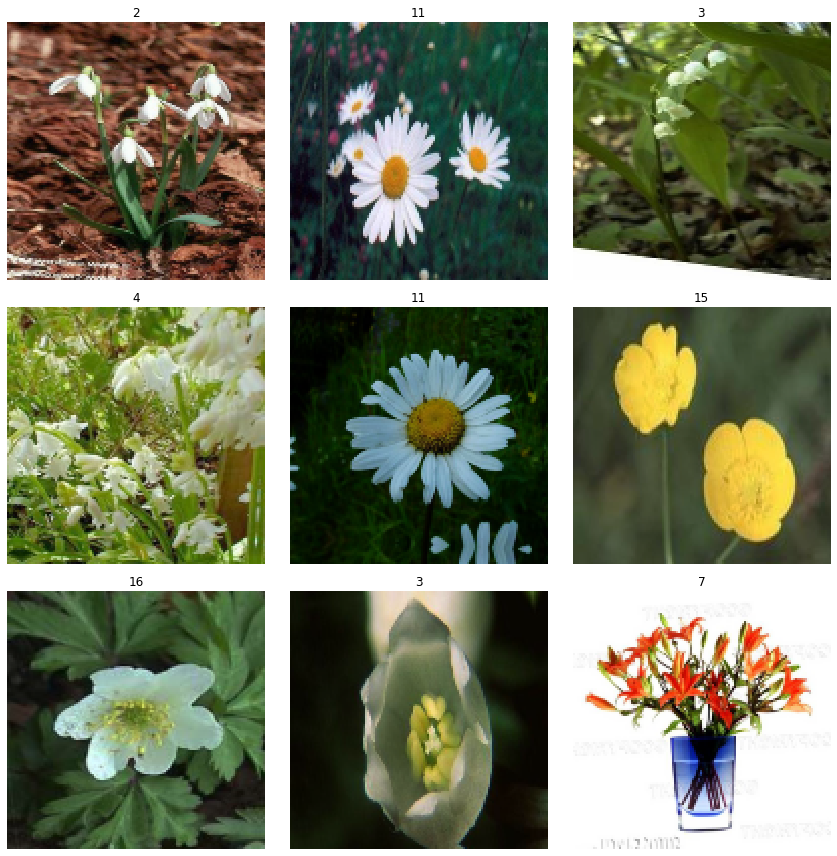

In [ ]:
data.show_batch(rows=3, ds_type=DatasetType.Train)

## Training
In fastai, `Learner` object implements the basic training loop. It is made up of the data, model, and metrics, etc. You can learn more about that [here](https://docs.fast.ai/basic_train.html#Basic-training-functionality)

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 336MB/s]


Let's take a look at our model

In [ ]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 1.45E-02


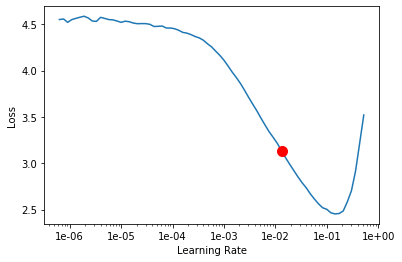

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, 1e-2, wd=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,2.246584,0.942069,0.753676,00:16
1,1.247904,0.660565,0.838235,00:16
2,0.859781,0.678881,0.819853,00:16
3,0.608937,0.414597,0.886029,00:16
4,0.459753,0.385104,0.893382,00:16


In [ ]:
learn.save('stage1')

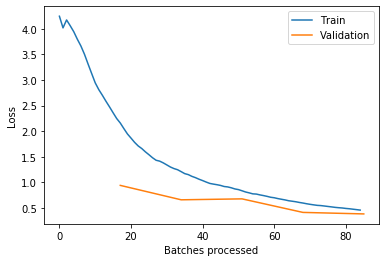

In [ ]:
# Plot training and validation losses
learn.recorder.plot_losses()

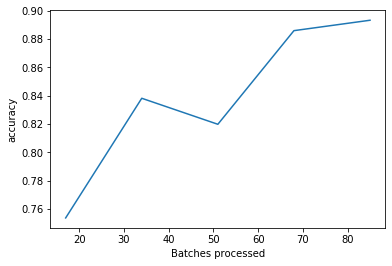

In [ ]:
# Plot metrics for validation set
learn.recorder.plot_metrics()

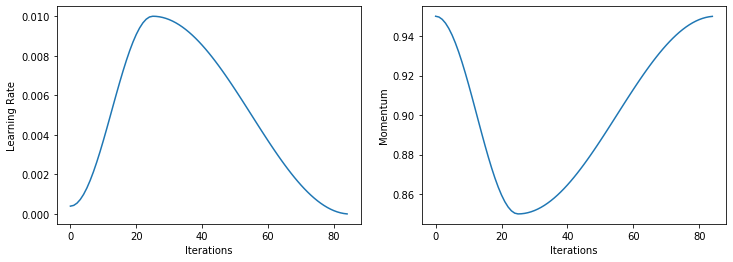

In [ ]:
# Shows how learning rate and momentum are varied in epoches
learn.recorder.plot_lr(show_moms=True) 

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.989883,54.278309,0.147059,00:16
1,1.598725,182.000458,0.095588,00:16
2,1.429645,2.175236,0.525735,00:16
3,1.144492,0.726506,0.757353,00:16
4,0.910404,0.561636,0.819853,00:16


We can see, we have destroyed our model, by keeping a 
large learning rate, let's use our saved model for
further work


In [ ]:
learn.load('stage1');
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 5.75E-05


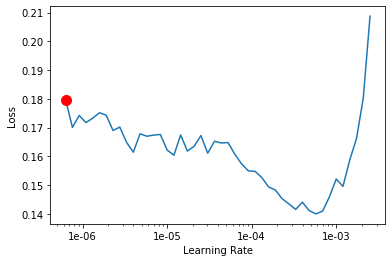

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.178313,0.370349,0.897059,00:15
1,0.149213,0.371213,0.904412,00:15
2,0.140309,0.351726,0.908088,00:15
3,0.122553,0.337213,0.908088,00:16
4,0.104275,0.329762,0.915441,00:16
5,0.093457,0.318132,0.915441,00:16
6,0.080223,0.305057,0.915441,00:16
7,0.073342,0.301872,0.915441,00:16
8,0.064437,0.313389,0.911765,00:17
9,0.066268,0.311922,0.911765,00:16


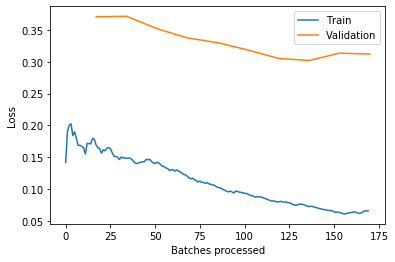

In [ ]:
learn.save('stage2')
learn.recorder.plot_losses()

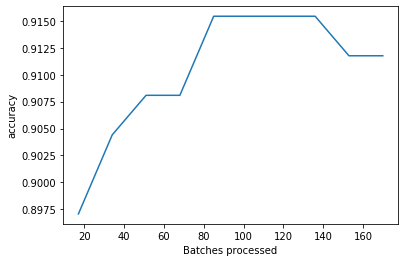

In [ ]:
learn.recorder.plot_metrics()

Let's analyze what has our model learned

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

assert len(data.valid_ds)==len(losses)==len(idxs)

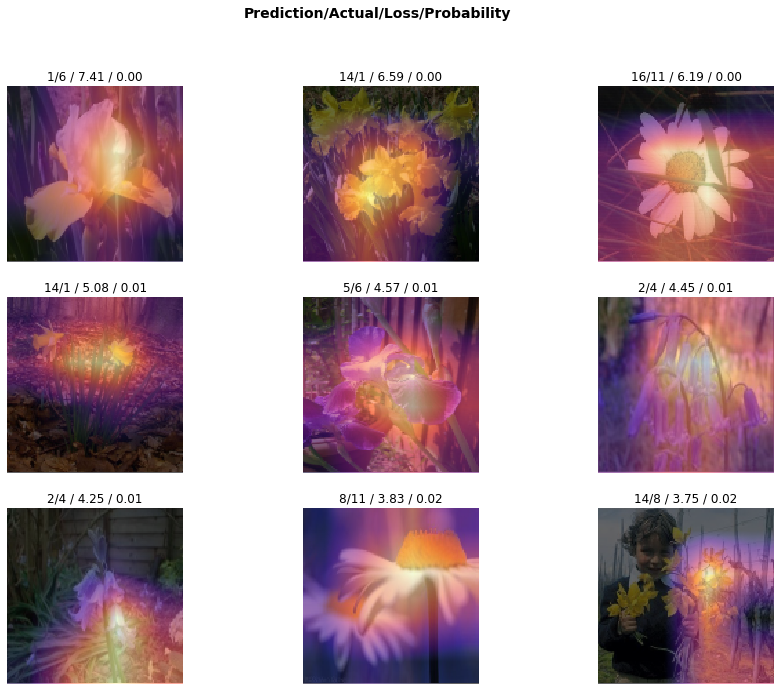

In [ ]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

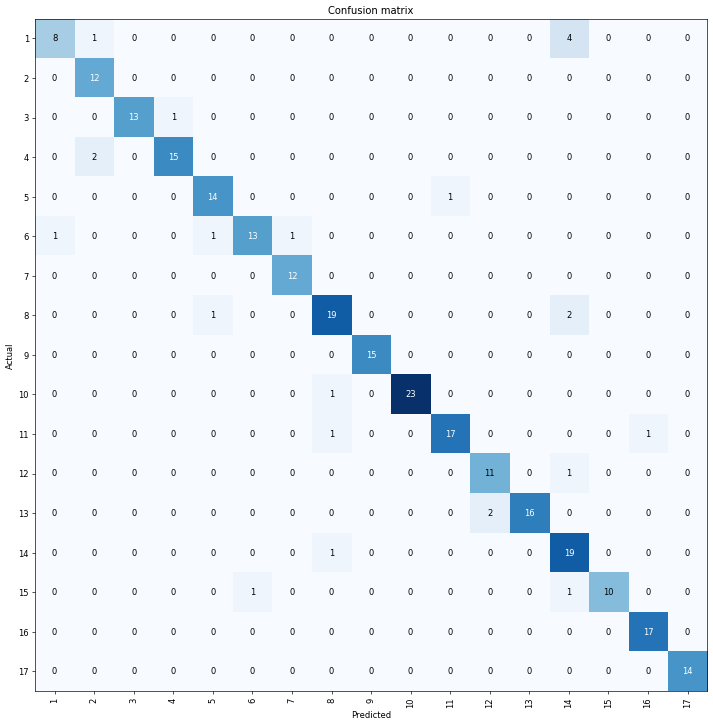

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[(1, 14, 4), (4, 2, 2), (8, 14, 2), (13, 12, 2)]

Let's train on our trained model on bigger images. It's
called progressive resize. Where you use your model trained
on smaller images as pretrained model for bigger images.
We have broken down the databunch api for this reason only, so now 
we just need to change the image size and get our dataset.

In [ ]:
data1 = (src.transform(tfms=tfms, size=256, resize_method=ResizeMethod.SQUISH)
         .databunch(bs=64, num_workers=2)
        )
learn.data = data1
learn.data

ImageDataBunch;

Train: LabelList (1088 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
7,16,15,6,4
Path: .;

Valid: LabelList (272 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
10,15,13,16,11
Path: .;

Test: None

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 5.75E-03


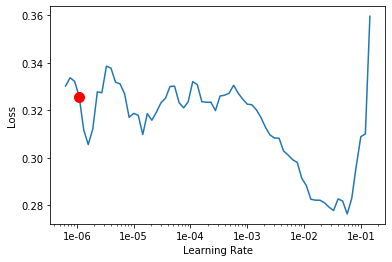

In [ ]:
learn.freeze()
learn.recorder.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4, 1e-3, wd=0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.290551,0.230444,0.926471,00:16
1,0.213296,0.175783,0.937500,00:16
2,0.162961,0.161823,0.948529,00:17
3,0.126889,0.166221,0.952206,00:17


In [ ]:
learn.save('stage3')

In [ ]:
learn.load('stage3');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.092078,0.196460,0.948529,00:17
1,0.082086,0.175553,0.948529,00:18
2,0.073446,0.170401,0.952206,00:18
3,0.067424,0.161605,0.955882,00:18
4,0.060864,0.161574,0.955882,00:17


In [ ]:
learn.save('stage4')

You can see, we have got better accuracy and faster 
convergence by doing progressive resize. It is 
a powerful technique and should always be used while
training image models.

## Prediction

Now that we have a decent model, let's see how well it does on the test set. 

We can use the `add_test` function directly here or could have done the same while creating the `Databunch` object. We just need to specify from where to get the images and it performs normalization automatically.

In [ ]:
learn.data.add_test(ImageList.from_df(path='.', df=X_test))

In [ ]:
learn.data

ImageDataBunch;

Train: LabelList (1088 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
7,16,15,6,4
Path: .;

Valid: LabelList (272 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
10,15,13,16,11
Path: .;

Test: LabelList (136 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: EmptyLabelList
,,,,
Path: .

Let's get the predictions on the test set

In [ ]:
proba, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
pred_class = torch.argmax(proba, dim=1)
pred_class = pred_class.numpy() + 1

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(pred_class, y_test)

0.9705882352941176

To learn more about fastai refer to their [docs](https://docs.fast.ai/) and [forums](https://forums.fast.ai/) and use fastai for some projects to get better understanding of it. You can train a classifier on Flowers 102 Dataset and try to get above 97% accuracy.